In [1]:
!pip freeze > requirements.txt

### Lib import

In [166]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score

import time

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import optuna


### Visual settings

In [2]:
%matplotlib inline
plt.style.use('seaborn-v0_8')

### Data reading

In [3]:
data = pd.read_csv('data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


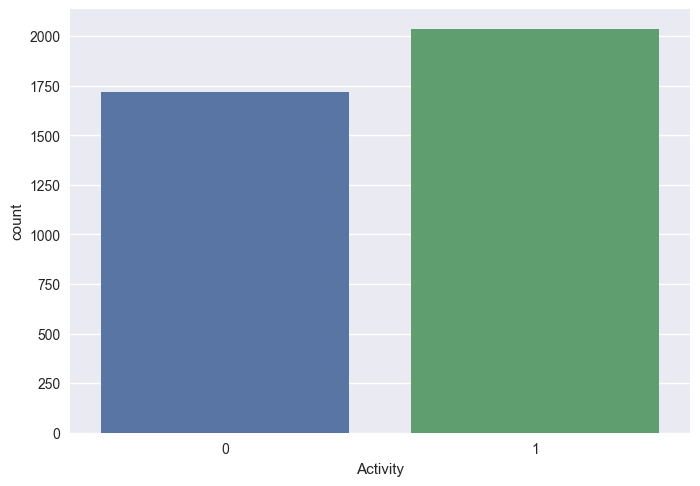

In [5]:
sns.countplot(data=data, x='Activity');

Classes are well ballanced, so we don`t need to stratify our train and test data.

In [6]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [7]:
random_state = 42

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, test_size = 0.2)

### Basic models

In [9]:
start = time.time()

log_reg = LogisticRegression(max_iter = 1000, random_state = random_state)

log_reg.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = log_reg.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))


Learning time: 2.6019957065582275
f1_score on train data: 0.89
f1_score on test data: 0.79


In [10]:
start = time.time()

rf = RandomForestClassifier(random_state = random_state)

rf.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = rf.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))


Learning time: 1.8688569068908691
f1_score on train data: 1.00
f1_score on test data: 0.83


### GridSearchCV

In [11]:
param_grid = [{'penalty': [None]},
              
              {'penalty': ['l2'],
               'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'],
               'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
              ]

grid_search_log = GridSearchCV(
    estimator = LogisticRegression(max_iter = 1000, random_state = random_state),
    param_grid = param_grid,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
    )

start = time.time()
  
grid_search_log.fit(X_train, y_train)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(grid_search_log.best_params_))


Optimisation time: 321.96632170677185
Best parameters:
{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [12]:
start = time.time()

log_reg_opt = LogisticRegression(**grid_search_log.best_params_, max_iter = 1000, random_state = random_state)

log_reg_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = log_reg_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = log_reg_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 0.9397165775299072
f1_score on train data: 0.85
f1_score on test data: 0.79


In [13]:
param_grid = {'n_estimators': list(range(80, 200, 20)),
              'min_samples_leaf': [4, 5, 6],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = random_state),
    param_grid = param_grid,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
    )

start = time.time()
  
grid_search_rf.fit(X_train, y_train)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(grid_search_rf.best_params_))

Optimisation time: 219.44901204109192
Best parameters:
{'max_depth': 28, 'min_samples_leaf': 4, 'n_estimators': 80}


In [14]:
start = time.time()

rf_opt = RandomForestClassifier(**grid_search_rf.best_params_, random_state = random_state)

rf_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = rf_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 1.2205684185028076
f1_score on train data: 0.96
f1_score on test data: 0.83


### RandomizedSearchCV

In [15]:
param_grid = [{'penalty': [None]},
              
              {'penalty': ['l2'],
               'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'],
               'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
              ]

random_search_log = RandomizedSearchCV(
    estimator = LogisticRegression(max_iter = 1000, random_state = random_state), 
    param_distributions = param_grid, 
    cv = 5, 
    n_iter = 10, 
    n_jobs = -1
    )

start = time.time()
  
random_search_log.fit(X_train, y_train)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(random_search_log.best_params_))

Optimisation time: 95.70389699935913
Best parameters:
{'solver': 'sag', 'penalty': 'l2', 'C': 0.1}


In [16]:
start = time.time()

log_reg_opt = LogisticRegression(**random_search_log.best_params_, max_iter = 1000, random_state = random_state)

log_reg_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = log_reg_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = log_reg_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 10.46279525756836
f1_score on train data: 0.85
f1_score on test data: 0.79


In [17]:
param_grid = {'n_estimators': list(range(80, 200, 20)),
              'min_samples_leaf': [4, 5, 6],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }

random_search_rf = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state = random_state), 
    param_distributions = param_grid, 
    cv = 5, 
    n_iter = 10, 
    n_jobs = -1
    )

start = time.time()
  
random_search_rf.fit(X_train, y_train)

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters:\n{}".format(random_search_rf.best_params_))

Optimisation time: 18.15121078491211
Best parameters:
{'n_estimators': 80, 'min_samples_leaf': 4, 'max_depth': 22}


In [18]:
start = time.time()

rf_opt = RandomForestClassifier(**random_search_rf.best_params_, random_state = random_state)

rf_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = rf_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 1.19439697265625
f1_score on train data: 0.96
f1_score on test data: 0.83


### Hyperopt

In [132]:
penalty_list = ['l1', 'l2', None]
solver_list = ['lbfgs', 'sag', 'liblinear', 'saga']
compatibilyty_dict = {'lbfgs': ['l2', None],
                      'sag': ['l2', None],
                      'liblinear': ['l1', 'l2'],
                      'saga': ['elasticnet', 'l1', 'l2', None]
                      }

In [133]:
space = {'penalty': hp.choice('penalty', penalty_list),
         'solver': hp.choice('solver', solver_list),
         'C': hp.uniform('C', 0.01, 1)
         }

In [134]:
def hyperopt_log(params, cv = 5, X = X_train, y = y_train, random_state = random_state):
    """Function to initiate hyperopt algorithm

    Args:
        params (Dictionary): Parameters for machine learning model
        cv (int): Cross-validation holds ratio.
        X (Dataframe): Features
        y (Series): Target feature
        random_state (int):  Defaults to random_state.

    Returns:
        float: f1 score or 0 in case of parameters incompatibility 
    """
    params = {'penalty': str(params['penalty']),
              'solver': str(params['solver']),
              'C': float(params['C'])
              }
    
    if params['penalty'] not in compatibilyty_dict[params['solver']]:
        return 0
                    
    model = LogisticRegression(**params, max_iter = 1000, random_state = random_state)

    model.fit(X, y)
    
    score = cross_val_score(model, X, y, cv = cv, scoring = "f1", n_jobs = -1).mean()
        
    return -score

In [135]:
start = time.time()

trials = Trials()

best = fmin(hyperopt_log,
            space = space,
            algo = tpe.suggest,
            max_evals = 20,
            trials = trials,
            rstate = np.random.default_rng(random_state)
           )

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters: {}".format(best))

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 25%|██▌       | 5/20 [02:10<05:40, 22.73s/trial, best loss: -0.7837204101572335]

c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 90%|█████████ | 18/20 [03:55<00:13,  6.79s/trial, best loss: -0.7839950244781424]

c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 20/20 [05:44<00:00, 17.21s/trial, best loss: -0.7839950244781424]
Optimisation time: 344.2267167568207
Best parameters: {'C': 0.4857515970241288, 'penalty': 0, 'solver': 3}


In [136]:
start = time.time()

log_reg_opt = LogisticRegression(
    penalty = penalty_list[best['penalty']],
    solver = solver_list[best['solver']],
    C = float(best['C']),
    max_iter = 1000,
    random_state = random_state
    )

log_reg_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = log_reg_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = log_reg_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 50.945929527282715
f1_score on train data: 0.85
f1_score on test data: 0.80


c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [137]:
space = {'n_estimators': hp.quniform('n_estimators', 80, 200, 20),
         'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 6, 1),
         'max_depth' : hp.quniform('max_depth', 20, 40, 10)
         }

In [167]:
def hyperopt_rf(params, cv = 5, X = X_train, y = y_train, random_state = random_state):
    """Function to initiate hyperopt algorithm

    Args:
        params (Dictionary): Parameters for machine learning model
        cv (int): Cross-validation holds ratio.
        X (Dataframe): Features
        y (Series): Target feature
        random_state (int):  Defaults to random_state.

    Returns:
        float: f1 score or 0 in case of parameters incompatibility 
    """
    params = {'n_estimators': int(params['n_estimators']),
              'min_samples_leaf': int(params['min_samples_leaf']),
              'max_depth': int(params['max_depth'])
             }
  
    model = RandomForestClassifier(**params, random_state=random_state)

    model.fit(X, y)
    
    score = cross_val_score(model, X, y, cv = cv, scoring = "f1", n_jobs = -1).mean()
    
    return -score

In [164]:
start = time.time()

trials = Trials()

best = fmin(hyperopt_rf,
            space = space,
            algo = tpe.suggest,
            max_evals = 20,
            trials = trials,
            rstate = np.random.default_rng(random_state)
           )

print('Optimisation time: {}'.format(time.time() - start))
print("Best parameters: {}".format(best))

100%|██████████| 20/20 [01:31<00:00,  4.57s/trial, best loss: -0.8051998212040885]
Optimisation time: 91.44578337669373
Best parameters: {'max_depth': 30.0, 'min_samples_leaf': 4.0, 'n_estimators': 80.0}


In [165]:
start = time.time()

rf_opt = RandomForestClassifier(
    n_estimators = int(best['n_estimators']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    random_state = random_state)

rf_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = rf_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 1.2385358810424805
f1_score on train data: 0.96
f1_score on test data: 0.83


### Optuna

In [174]:
def optuna_log(trial):
    """Function to optimize with optuna algorith

    Args:
        trial (optuna.trial): a single execution of the objective function

    Returns:
      float: f1 score
    """
    C_value = trial.suggest_float('C', 0.01, 1, log = False)
    penalty_name = trial.suggest_categorical('penalty', penalty_list)
    solver_name = trial.suggest_categorical('solver', solver_list)

    if penalty_name not in compatibilyty_dict[solver_name]:
        return 0
  
    if penalty_name is None:    
        model = LogisticRegression(
            penalty = penalty_name,
            max_iter = 1000,
            random_state = random_state
            )
    else:
        model = LogisticRegression(
            penalty = penalty_name,
            solver = solver_name,
            C = C_value,
            max_iter = 1000,
            random_state = random_state
            )  
  
    model.fit(X_train, y_train)
  
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = "f1", n_jobs = -1).mean()
  
    return score

In [175]:
start = time.time()

study = optuna.create_study(study_name="LogisticRegression", direction="maximize")

study.optimize(optuna_log, n_trials=20)
print('Optimisation time: {}'.format(time.time() - start))

[I 2023-02-12 00:05:44,587] A new study created in memory with name: LogisticRegression
c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[I 2023-02-12 00:06:03,403] Trial 0 finished with value: 0.7250877932339528 and parameters: {'C': 0.5270383924139143, 'penalty': None, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7250877932339528.
c:\Users\nokac\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1)

Optimisation time: 178.58898615837097


In [176]:
print("Best parameters: {}".format(study.best_params))

Best parameters: {'C': 0.06497862311867433, 'penalty': 'l2', 'solver': 'liblinear'}


In [177]:
start = time.time()

log_reg_opt = LogisticRegression(
    **study.best_params,
    max_iter = 1000,
    random_state = random_state
    )

log_reg_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = log_reg_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = log_reg_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 0.25714826583862305
f1_score on train data: 0.85
f1_score on test data: 0.79


In [178]:
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 80, 200, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 4, 6, 1)
    max_depth = trial.suggest_int('max_depth', 20, 40, 10)
    
    model = RandomForestClassifier(
        n_estimators = n_estimators,
        min_samples_leaf = min_samples_leaf,
        max_depth = max_depth,
        random_state = random_state
        )
    
    model.fit(X_train, y_train)
  
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = "f1", n_jobs = -1).mean()
  
    return score    

In [179]:
start = time.time()

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

study.optimize(optuna_rf, n_trials=20)
print('Optimisation time: {}'.format(time.time() - start))

[I 2023-02-12 00:17:11,957] A new study created in memory with name: RandomForestClassifier
[I 2023-02-12 00:17:17,950] Trial 0 finished with value: 0.7994377592490409 and parameters: {'n_estimators': 120, 'min_samples_leaf': 6, 'max_depth': 20}. Best is trial 0 with value: 0.7994377592490409.
[I 2023-02-12 00:17:24,593] Trial 1 finished with value: 0.7990635907672139 and parameters: {'n_estimators': 200, 'min_samples_leaf': 6, 'max_depth': 40}. Best is trial 0 with value: 0.7994377592490409.
[I 2023-02-12 00:17:28,205] Trial 2 finished with value: 0.7943184152560021 and parameters: {'n_estimators': 80, 'min_samples_leaf': 6, 'max_depth': 30}. Best is trial 0 with value: 0.7994377592490409.
[I 2023-02-12 00:17:34,105] Trial 3 finished with value: 0.800067278572184 and parameters: {'n_estimators': 160, 'min_samples_leaf': 4, 'max_depth': 30}. Best is trial 3 with value: 0.800067278572184.
[I 2023-02-12 00:17:39,728] Trial 4 finished with value: 0.7990635907672139 and parameters: {'n_est

Optimisation time: 92.32631516456604


In [180]:
print("Best parameters: {}".format(study.best_params))

Best parameters: {'n_estimators': 140, 'min_samples_leaf': 4, 'max_depth': 20}


In [181]:
start = time.time()

rf_opt = RandomForestClassifier(
    **study.best_params,
    random_state = random_state)

rf_opt.fit(X_train, y_train)

print('Learning time: {}'.format(time.time() - start))

y_train_pred = rf_opt.predict(X_train)
print('f1_score on train data: {:.2f}'.format(f1_score(y_train, y_train_pred)))
y_test_pred = rf_opt.predict(X_test)
print('f1_score on test data: {:.2f}'.format(f1_score(y_test, y_test_pred)))

Learning time: 2.1512451171875
f1_score on train data: 0.96
f1_score on test data: 0.83
